In [1]:
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from joblib import dump, load

## Evaluation of the data

In [2]:
df = pd.read_table("dialog_acts.dat", header=None, names=['data'])
df['act'] = df['data'].str.split(' ').str[0]
df['sentence'] = df['data'].str.split(' ').str[1:]
df['sentence'] = df['sentence'].str.join(' ')
df.drop(labels='data', inplace=True, axis=1)

In [3]:
df.act.value_counts()

inform      10160
request      6494
thankyou     3259
reqalts      1747
null         1612
affirm       1156
negate        435
bye           266
confirm       172
hello          93
repeat         33
ack            28
deny           27
restart        14
reqmore         5
Name: act, dtype: int64

In [4]:
contraptions = {'doesnt': "does not",
               'im': 'i am', 
               'dont': 'do not',
               'id': 'i would'}

In [5]:
df['sentence'] = df['sentence'].replace(contraptions, regex=True)

In [6]:
df['sentence_length'] = df.sentence.str.split().apply(len)

In [7]:
df['sentence_length'].describe()

count    25501.000000
mean         3.841026
std          3.067537
min          1.000000
25%          2.000000
50%          3.000000
75%          5.000000
max         24.000000
Name: sentence_length, dtype: float64

## Evaluation of the machine learning and baseline systems

In [8]:
x = df['sentence']
y = df['act']
train_categories = 0
test_categories = 0

while train_categories < 15 and test_categories < 15:
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15)
    train_categories = len(y_train.value_counts())
    test_categories = len(y_test.value_counts())

    
print(f'\nSamples in train set: {len(x_train)}')
print(f'Samples in test set: {len(x_test)}')


Samples in train set: 21675
Samples in test set: 3826


In [9]:
i = 0
def create_cf_matrix(y_test, y_pred):
    global i 
    cf_matrix = confusion_matrix(y_test, y_pred, labels=list(y_test.unique()))
    cm_sum = np.sum(cf_matrix, axis=1, keepdims=True)
    f = plt.figure(figsize=(11,11))
    ax= plt.subplot()
    sns.heatmap(cf_matrix/cm_sum, annot=True, ax=ax, fmt='0.1%', cmap='Blues') #annot=True to annotate cells
    
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(list(y_test.unique()), rotation=45)
    ax.yaxis.set_ticklabels(list(y_test.unique()), rotation=45)
    
    titles = ['majority', 'rule_based', 'decision_tree', 'SVM', 'MLP']
    plt.savefig(f'confusion_matrix_{titles[i]}')
    i += 1

#### Baseline

Accuracy of the majority class classifier on the test samples:
accuracy: 0.3996340825927862
precision: 0.15970739996977787
recall: 0.3996340825927862


D:\Anaconda\envs\mair\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


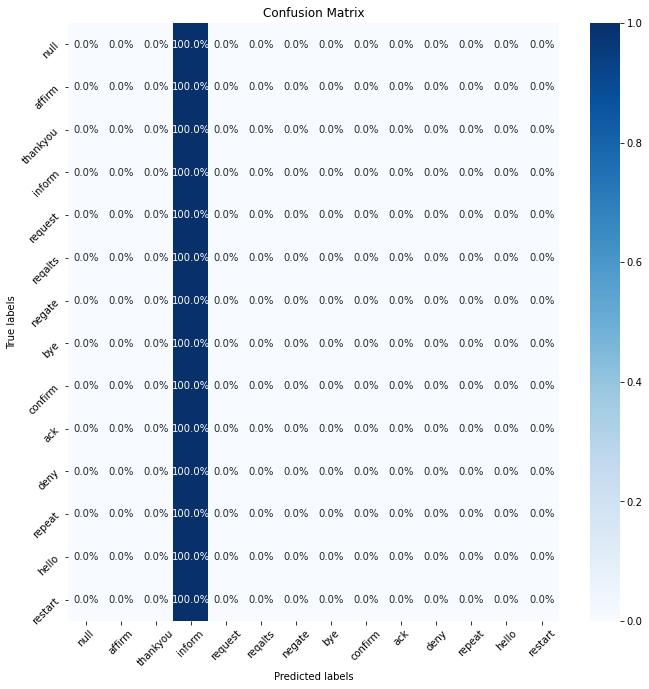

In [10]:
print('Accuracy of the majority class classifier on the test samples:')
y_pred = len(y_test) * ['inform']
print(f"accuracy: {accuracy_score(y_test, y_pred)}")
print(f"precision: {precision_score(y_test, y_pred, average='weighted')}")
print(f"recall: {recall_score(y_test, y_pred, average='weighted')}")
create_cf_matrix(y_test, y_pred)

Accuracy of the rulebased classifier on the test samples
accuracy: 0.30658651332984843
precision: 0.8908162260480305
recall: 0.30658651332984843


D:\Anaconda\envs\mair\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


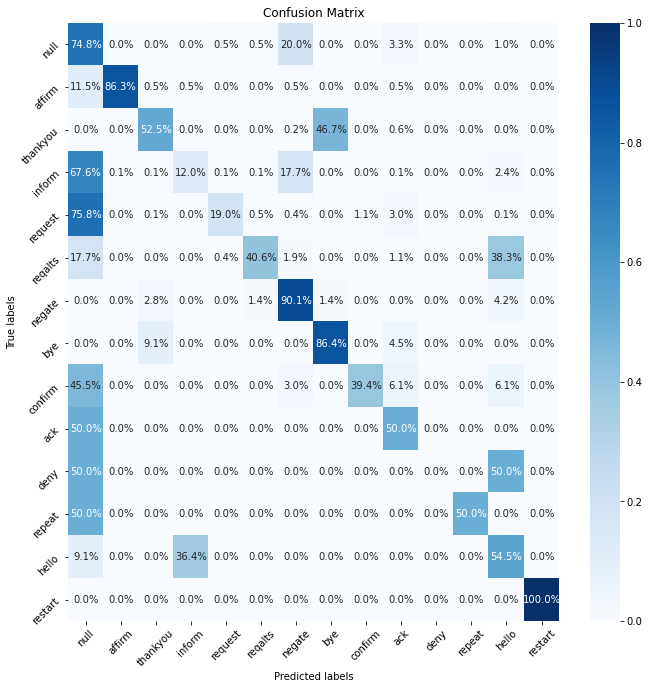

In [11]:
print('Accuracy of the rulebased classifier on the test samples')
# dictionary with act as key and corresponding words as values
rules = {'ack': ['okay', 'okay um', 'alright'], 'affirm': ['yes right', 'right', 'yes'],
         'bye': ['see you', 'good bye', 'bye'], 'confirm': ['is it'], 'deny': ['i dont want'],
         'hello': ['hi', 'hello'],
         'inform': ['looking for'], 'negate': ['no'], 'repeat': ['can you repeat that', 'what did you say'],
         'reqalts': ['how about'], 'reqmore': ['more'], 'request': ['what is', 'where'], 'restart': ['start over'],
         'thankyou': ['thank you', 'thanks']}

y_pred = []

for x in x_test:
    acts = []
    for k, v in rules.items():
        if any(keywords in x.lower() for keywords in v):
            acts.append(k)
    if not acts:
        y_pred.append('null')
    else:
        y_pred.append(random.choice(acts))

print(f"accuracy: {accuracy_score(y_test, y_pred)}")
print(f"precision: {precision_score(y_test, y_pred, average='weighted')}")
print(f"recall: {recall_score(y_test, y_pred, average='weighted')}")
create_cf_matrix(y_test, y_pred)

#### Machine learning

In [12]:
max_sentences = 0.85
min_sentences = 1
BOW_vect = CountVectorizer(max_df=max_sentences, min_df=1, lowercase=True, strip_accents='ascii')
x_train_counts = BOW_vect.fit_transform(x_train)
dump(BOW_vect, 'BOW_vect.joblib')

['BOW_vect.joblib']

Finding best hyperparameters for Decision tree using grid search and cross validation.
Fitting 3 folds for each of 72 candidates, totalling 216 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done 216 out of 216 | elapsed:    9.6s finished


Evaluation of the best hyperparameters on the test set
accuracy: 0.9550444328280188
precision: 0.9533607453385126
recall: 0.9550444328280188
Saving the best model to decisionTree.joblib


D:\Anaconda\envs\mair\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


['decisionTree.joblib']

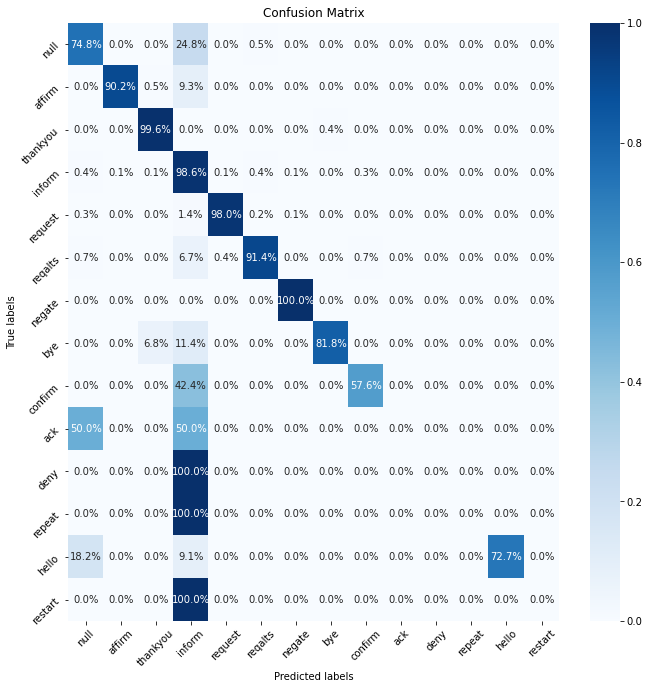

In [13]:
print('Finding best hyperparameters for Decision tree using grid search and cross validation.')
params = {'max_depth': list(range(1,25)),
          'min_samples_split': [10, 50,100]}
grid_search_cv = GridSearchCV(DecisionTreeClassifier(), params, verbose=1, cv=3, n_jobs=-1)
grid_search_cv.fit(x_train_counts, y_train)

x_test_counts = BOW_vect.transform(x_test)
y_pred = grid_search_cv.predict(x_test_counts)
print('Evaluation of the best hyperparameters on the test set')
print(f"accuracy: {accuracy_score(y_test, y_pred)}")
print(f"precision: {precision_score(y_test, y_pred, average='weighted')}")
print(f"recall: {recall_score(y_test, y_pred, average='weighted')}")
print(f"Saving the best model to decisionTree.joblib")
create_cf_matrix(y_test, y_pred)
dump(grid_search_cv, 'decisionTree.joblib')

Finding best parameters for SVM using grid search and cross validation.
Fitting 3 folds for each of 64 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed:  1.1min finished


Evaluation of the best hyperparameters on the test set
accuracy: 0.9777835859905907
precision: 0.9791237117007141
recall: 0.9777835859905907
Saving the best model to SVM.joblib


D:\Anaconda\envs\mair\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


['SVM.joblib']

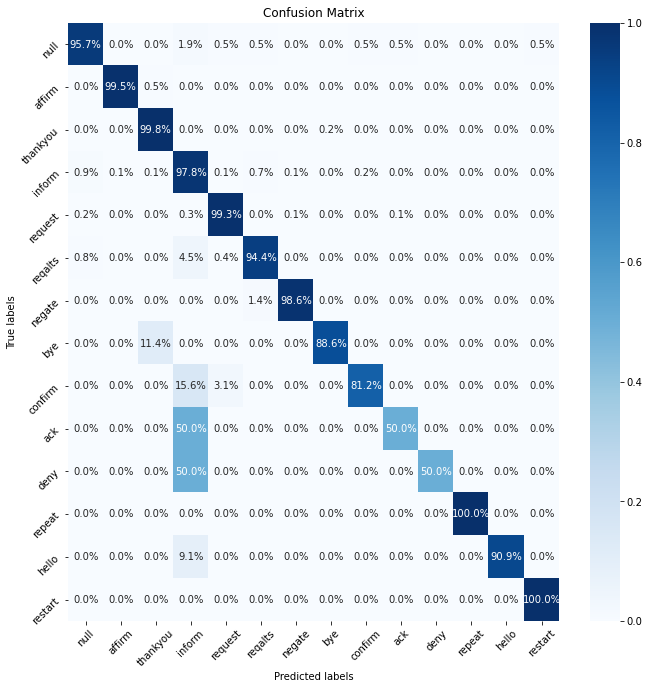

In [14]:
print('Finding best parameters for SVM using grid search and cross validation.')

params = params = {
    "loss" : ["hinge", "log", "squared_hinge", "modified_huber"],
    "alpha" : [0.0001, 0.001, 0.01, 0.1],
    "penalty" : ["l2", "l1", "none", "elasticnet"],
}

grid_search_cv = GridSearchCV(SGDClassifier(), params, verbose=1, cv=3, n_jobs=-1)
grid_search_cv.fit(x_train_counts, y_train)

x_test_counts = BOW_vect.transform(x_test)
y_pred = grid_search_cv.predict(x_test_counts)
print('Evaluation of the best hyperparameters on the test set')
print(f"accuracy: {accuracy_score(y_test, y_pred)}")
print(f"precision: {precision_score(y_test, y_pred, average='weighted')}")
print(f"recall: {recall_score(y_test, y_pred, average='weighted')}")
print(f"Saving the best model to SVM.joblib")
create_cf_matrix(y_test, y_pred)
dump(grid_search_cv, 'SVM.joblib')

In [15]:
results = pd.DataFrame({'utterance': x_test, 'act': y_test, 'predicted_act':y_pred})
results['utterance_length'] = results.utterance.str.split().apply(len)
corrects = results[(results.act == results.predicted_act)]
mistakes = results[(results.act != results.predicted_act)]
print(f'Distribution True:\n{mistakes.act.value_counts()}')
print(f'Distribution predicted:\n{mistakes.predicted_act.value_counts()}')
print(f'Utterance length description:\n {results.utterance_length.describe()}')
print(f'Utterance length description:\n {mistakes.utterance_length.describe()}')

Distribution True:
inform      34
reqalts     16
null         9
request      8
confirm      7
bye          5
affirm       1
ack          1
negate       1
deny         1
hello        1
thankyou     1
Name: act, dtype: int64
Distribution predicted:
inform      27
null        17
reqalts     13
thankyou     7
request      5
reqmore      4
confirm      4
affirm       2
ack          2
negate       2
restart      1
bye          1
Name: predicted_act, dtype: int64
Utterance length description:
 count    3826.000000
mean        3.865656
std         3.095641
min         1.000000
25%         2.000000
50%         3.000000
75%         5.000000
max        19.000000
Name: utterance_length, dtype: float64
Utterance length description:
 count    85.000000
mean      4.835294
std       2.939254
min       1.000000
25%       2.000000
50%       5.000000
75%       7.000000
max      12.000000
Name: utterance_length, dtype: float64


In [16]:
print(mistakes)

                                               utterance      act  \
3329                                            air tran   inform   
9340   uh is there a korean restaurant in the center ...  confirm   
3203                                              prices  request   
17548                                               fine      ack   
1312                        ah how bout an expensive one  reqalts   
...                                                  ...      ...   
14189                    what about the other restaurant   inform   
13792                                               halo    hello   
12151                     yes uh turkish food in my area   inform   
12034                              what about asian food   inform   
5754                                            air tran   inform   

      predicted_act  utterance_length  
3329           null                 2  
9340         inform                11  
3203         inform                 1  
17548      

Finding best parameters for MLP using grid search and cross validation.


D:\Anaconda\envs\mair\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Evaluation of the best hyperparameters on the test set
accuracy: 0.9803972817564035
precision: 0.981028756342493
recall: 0.9803972817564035
Saving the best model to MLP.joblib


['MLP.joblib']

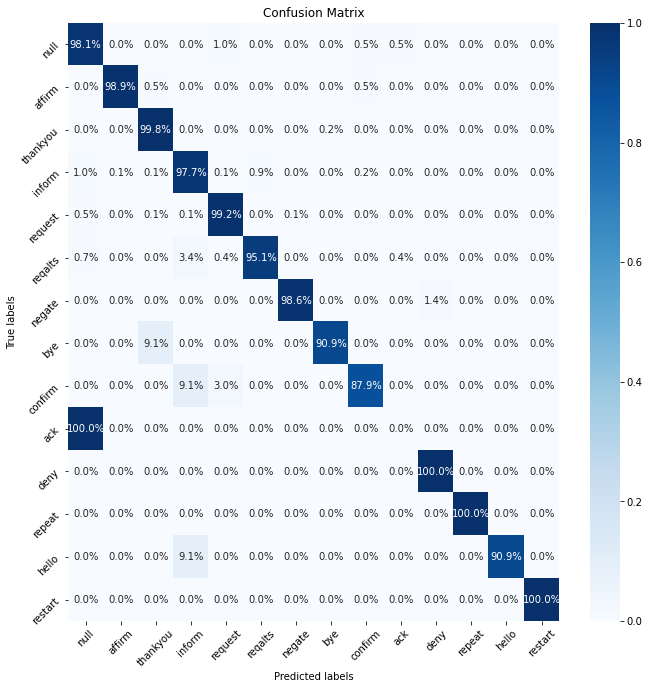

In [17]:
print('Finding best parameters for MLP using grid search and cross validation.')
params = {
    'hidden_layer_sizes': [(10,30,10),(20, 20), (20)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

grid_search_cv = GridSearchCV(MLPClassifier(max_iter=100), params, n_jobs=-1, cv=3)
grid_search_cv.fit(x_train_counts, y_train)

x_test_counts = BOW_vect.transform(x_test)
y_pred = grid_search_cv.predict(x_test_counts)
print('Evaluation of the best hyperparameters on the test set')
print(f"accuracy: {accuracy_score(y_test, y_pred)}")
print(f"precision: {precision_score(y_test, y_pred, average='weighted')}")
print(f"recall: {recall_score(y_test, y_pred, average='weighted')}")
print(f"Saving the best model to MLP.joblib")
create_cf_matrix(y_test, y_pred)
dump(grid_search_cv, 'MLP.joblib')

In [18]:
results = pd.DataFrame({'utterance': x_test, 'act': y_test, 'predicted_act':y_pred})
results['utterance_length'] = results.utterance.str.split().apply(len)
corrects = results[(results.act == results.predicted_act)]
mistakes = results[(results.act != results.predicted_act)]
print(f'Distribution True:\n{mistakes.act.value_counts()}')
print(f'Distribution predicted:\n{mistakes.predicted_act.value_counts()}')
print(f'Utterance length description:\n {results.utterance_length.describe()}')
print(f'Utterance length description:\n {mistakes.utterance_length.describe()}')

Distribution True:
inform      35
reqalts     13
request      8
null         4
bye          4
confirm      4
affirm       2
ack          2
negate       1
hello        1
thankyou     1
Name: act, dtype: int64
Distribution predicted:
null        24
inform      14
reqalts     14
thankyou     7
request      5
confirm      5
ack          2
affirm       1
negate       1
deny         1
bye          1
Name: predicted_act, dtype: int64
Utterance length description:
 count    3826.000000
mean        3.865656
std         3.095641
min         1.000000
25%         2.000000
50%         3.000000
75%         5.000000
max        19.000000
Name: utterance_length, dtype: float64
Utterance length description:
 count    75.000000
mean      4.826667
std       2.979086
min       1.000000
25%       2.000000
50%       5.000000
75%       7.000000
max      13.000000
Name: utterance_length, dtype: float64


In [19]:
print(mistakes)

                            utterance      act predicted_act  utterance_length
3329                         air tran   inform          null                 2
3203                           prices  request          null                 1
17548                            fine      ack          null                 1
1312     ah how bout an expensive one  reqalts        inform                 6
18173  thats fine how bout asian food  reqalts        inform                 6
...                               ...      ...           ...               ...
12151  yes uh turkish food in my area   inform        affirm                 7
12034           what about asian food   inform       reqalts                 4
5754                         air tran   inform          null                 2
5687        ah thank you phone number  request      thankyou                 5
11813                           venue   inform          null                 1

[75 rows x 4 columns]
